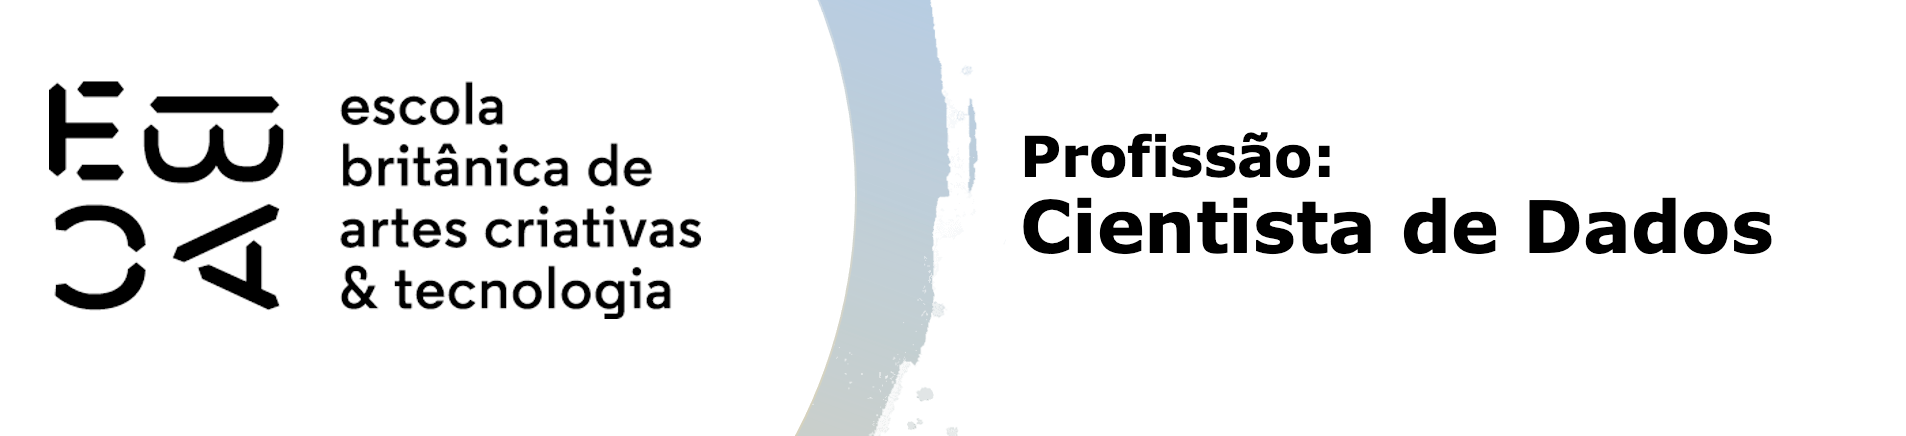

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels.api as sm

import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('./previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [3]:
#Verificando se há valores ausentes
df.isnull().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [4]:
#Calculando a média de tempo de emprego
med_temp = df['tempo_emprego'].mean()

#Fazendo a substituição dos valores ausentes pela média
df['tempo_emprego'].fillna(med_temp, inplace=True)

#retirando a coluna index
df.drop(['index'], axis=1, inplace=True)

# Certifique-se de que o seu índice seja do tipo datetime
df.index = pd.to_datetime(df.index)

# Organizar o índice para exibir apenas o mês e o ano
df.index = df.index.to_period('M')

In [5]:
#Verificando se há valores ausentes após tratamento.
df.isnull().sum()

data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

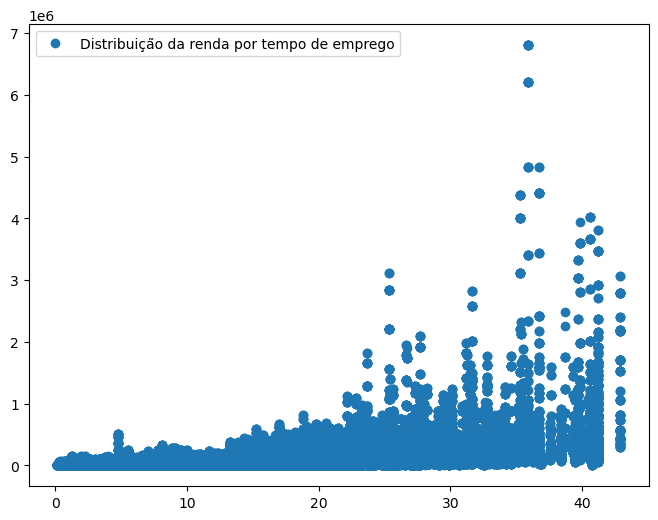

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df.tempo_emprego,
        df.renda,
        "o",
        label=("Distribuição da renda por tempo de emprego"),
        alpha=1)
ax.legend()

In [7]:
#substituindo renda por log(renda)
df['renda'] = np.log(df['renda'])

#criando uma coluna com a categoria de tempo de emprego
tempo_emprego_cat, quebras = pd.qcut(df.tempo_emprego,
                                     15,
                                     duplicates='drop',
                                     retbins=True)

renda_cat, quebras = pd.cut(df.renda, 10, duplicates='drop', retbins=True)

df['tempo_emprego_cat'] = tempo_emprego_cat
df['renda_cat'] = renda_cat

In [8]:
#criando uma coluna com a média de tempo de emprego para cada categoria
df['media_tempo_emprego'] = df.groupby(
    'tempo_emprego_cat')['tempo_emprego'].transform('mean')

df['media_renda'] = df.groupby('renda_cat')['renda'].transform('mean')

df.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,renda_cat,media_tempo_emprego,media_renda
1970-01,2015-01-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,9.318131,"(13.299, 18.337]","(9.027, 10.145]",15.459653,9.540665
1970-01,2015-01-01,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,7.793508,"(8.721, 10.438]","(6.792, 7.91]",9.534708,7.468176
1970-01,2015-01-01,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,9.528769,"(7.746, 8.721]","(9.027, 10.145]",8.239489,9.540665
1970-01,2015-01-01,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,7.767196,"(1.033, 1.877]","(6.792, 7.91]",1.448497,7.468176
1970-01,2015-01-01,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,6.673020,"(1.033, 1.877]","(5.675, 6.792]",1.448497,6.450744


após tratamento da variável renda e categorização de tempo de emprego


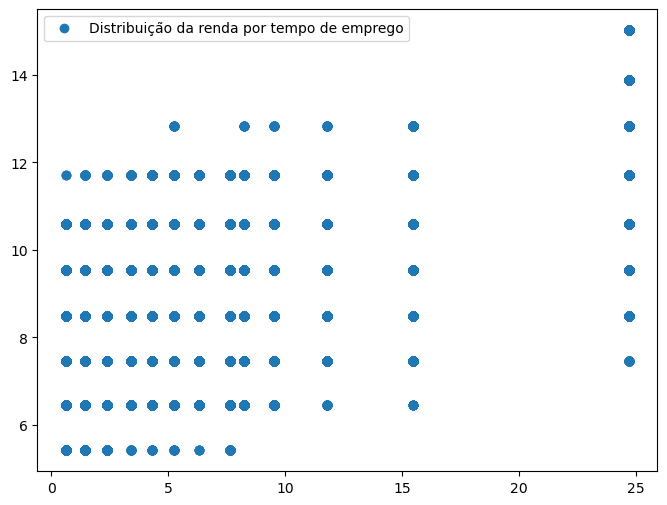

In [9]:
#plotando gráfico de renda

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df.media_tempo_emprego,
        df.media_renda,
        "o",
        label=("Distribuição da renda por tempo de emprego"),
        alpha=1)
ax.legend()
print(
    'após tratamento da variável renda e categorização de tempo de emprego')

In [10]:
#Separando os dados entre treino e teste

treino, teste = train_test_split(df, test_size=0.3, random_state=42)

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [11]:
# Treinando modelo de Regressão.

res = smf.ols(
    'renda ~ sexo+posse_de_veiculo+posse_de_imovel+qtd_filhos+tipo_renda+idade+tempo_emprego+qt_pessoas_residencia',
    data=treino).fit()

print(f'R-quadrado: {res.rsquared:.2%}')

res.summary()

R-quadrado: 39.33%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 3.095e+04
Date:                Fri, 12 May 2023   Prob (F-statistic):               0.00
Time:                        13:15:55   Log-Likelihood:            -7.4527e+05
No. Observations:              525000   AIC:                         1.491e+06
Df Residuals:                  524988   BIC:                         1.491e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          7.7403      0.010    802.484      0.000       7.721       7.759
sexo[T.M]                          0.1253      0.003     38.698      0.000       0.119       0.132
posse_de_veiculo[T.S]              0.0145      0.003      4.719      0.000       0.009       0.021
posse_de_imovel[T.S]               0.1855      0.003     62.392      0.000       0.180       0.191
tipo_renda[T.Bolsista]            -0.1669      0.061     -2.717      0.007      -0.287      -0.047
tipo_renda[T.Empresário]           0.1520      0.003     43.624      0.000       0.145       0.159
tipo_renda[T.Pensionista]         -0.2937      0.005    -59.197      0.000      -0.303      -0.284
tipo_renda[T.Servidor público]     0.1425      0.005     27.836      0.000       0.132       0.153
qtd_filhos                         0.0163      0.004      3.893      0.000       0.008       0.025
idade                              0.0035      0.000     19.816      0.000       0.003       0.004
tempo_emprego                      0.1291      0.000    530.916      0.000       0.129       0.130
qt_pessoas_residencia             -0.0115      0.003     -3.392      0.001      -0.018      -0.005
==============================================================================
Omnibus:                     2704.148   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1956.604
Skew:                          -0.022   Prob(JB):                         0.00
Kurtosis:                       2.704   Cond. No.                     2.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

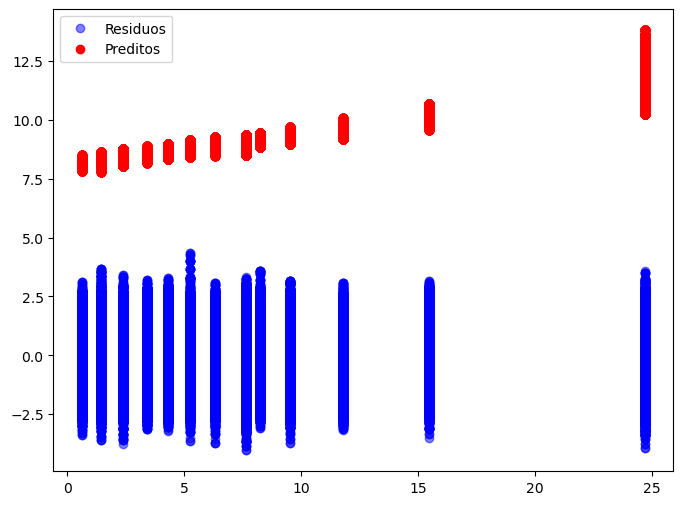

In [12]:
treino['residuos'] = res.resid
treino['preditos'] = res.fittedvalues

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(treino.media_tempo_emprego,
        treino.residuos,
        "o",
        label=("Residuos"),
        alpha=0.5,
        color='b')

ax.plot(treino.media_tempo_emprego,
        treino.preditos,
        "o",
        label=("Preditos"),
        alpha=1,
        color='r')

ax.legend()
plt.show()

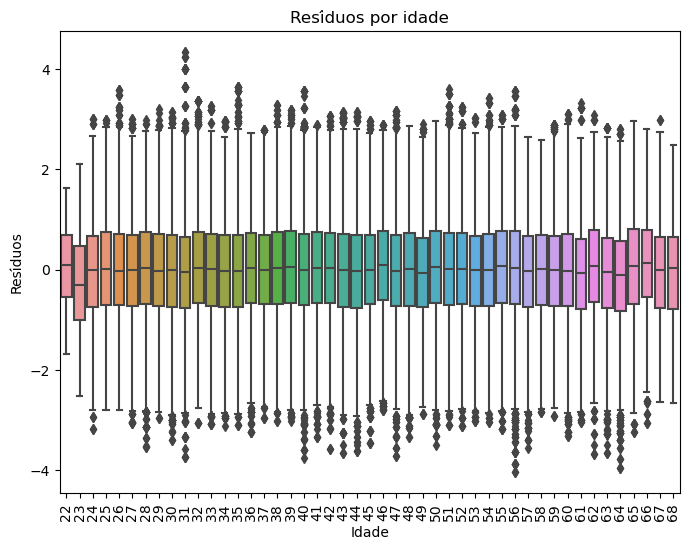

In [14]:
#Verificando padrão dos resíduos versus as variáveis explicativas
#idade

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=treino['idade'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Idade')
plt.xticks(rotation=90)
ax.set_title('Resíduos por idade')

plt.show()

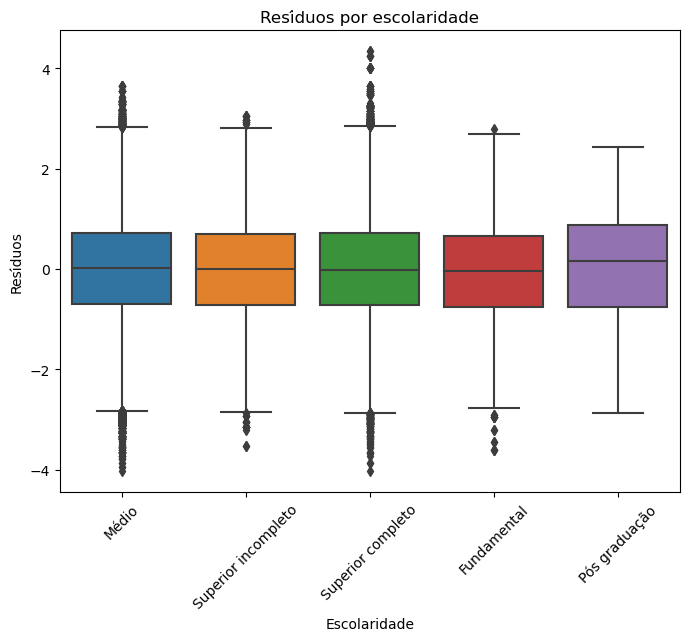

In [15]:
#Escolaridade

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=treino['educacao'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Escolaridade')
plt.xticks(rotation=45)
ax.set_title('Resíduos por escolaridade')

plt.show()

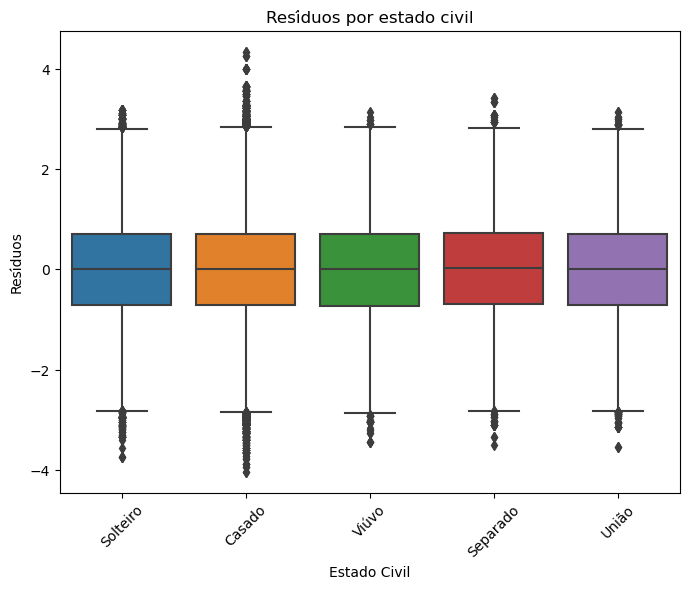

In [16]:
#Verificando padrão dos resíduos versus as variáveis explicativas
#Estado Civil

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=treino['estado_civil'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Estado Civil')
plt.xticks(rotation=45)
ax.set_title('Resíduos por estado civil')

plt.show()

Text(0.5, 1.0, 'Resíduos por tipo de renda')

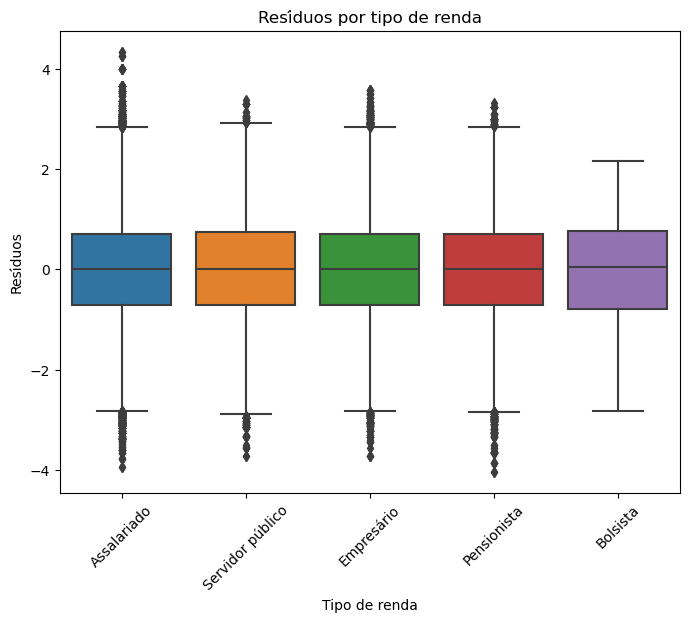

In [17]:
#Verificando padrão dos resíduos versus as variáveis explicativas
#Tipo de renda

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=treino['tipo_renda'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Tipo de renda')
plt.xticks(rotation=45)

ax.set_title('Resíduos por tipo de renda')

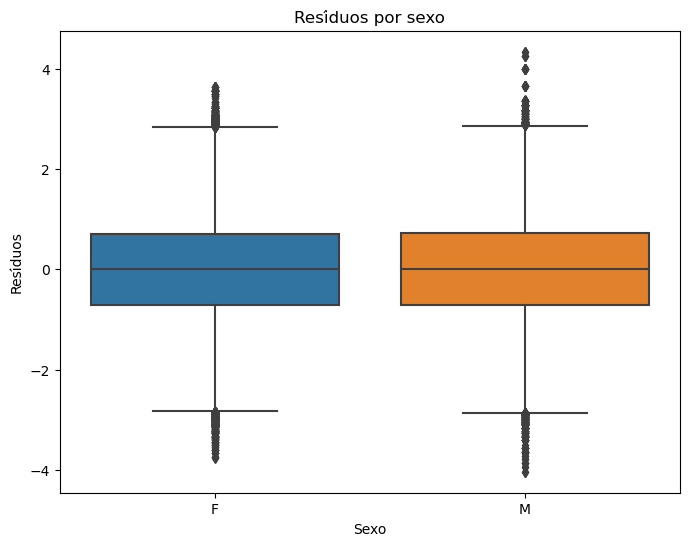

In [18]:
# Verificando padrão dos resíduos versus as variáveis explicativas
#Sexo

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=treino['sexo'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Sexo')
plt.xticks(rotation=0)
ax.set_title('Resíduos por sexo')

plt.show()

Text(0.5, 1.0, 'Resíduos por quantidade de filhos')

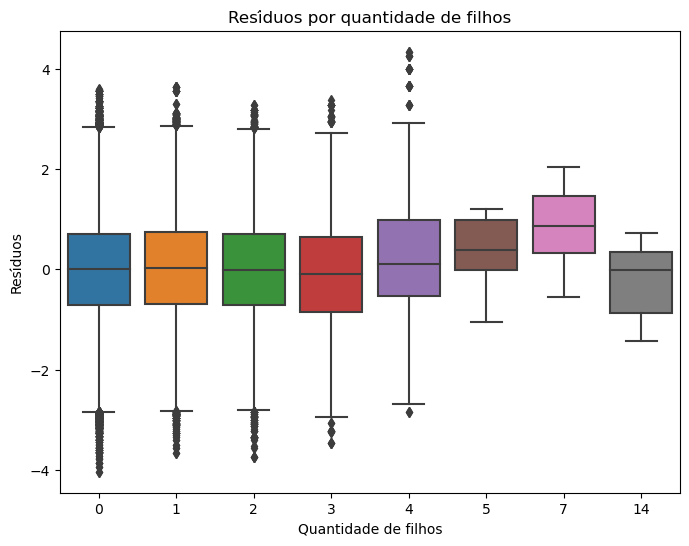

In [19]:
#Verificando padrão dos resíduos versus as variáveis explicativas
#Quantidade de filhos

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=treino['qtd_filhos'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Quantidade de filhos')
plt.xticks(rotation=0)

ax.set_title('Resíduos por quantidade de filhos')

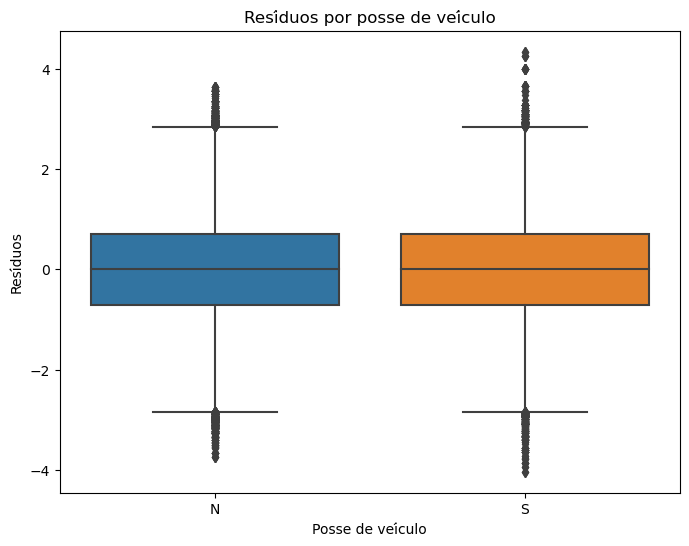

In [20]:
#Verificando padrão dos resíduos versus as variáveis explicativas
#posse de veiculo

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=treino['posse_de_veiculo'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Posse de veículo')
plt.xticks(rotation=0)

ax.set_title('Resíduos por posse de veículo')

plt.show()

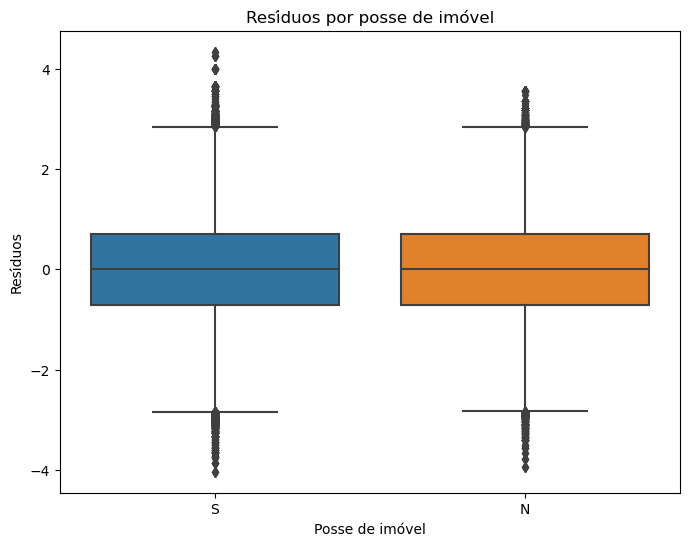

In [21]:
#Verificando padrão dos resíduos versus as variáveis explicativas
#Posse de imovel

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=treino['posse_de_imovel'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Posse de imóvel')
plt.xticks(rotation=0)

ax.set_title('Resíduos por posse de imóvel')

plt.show()

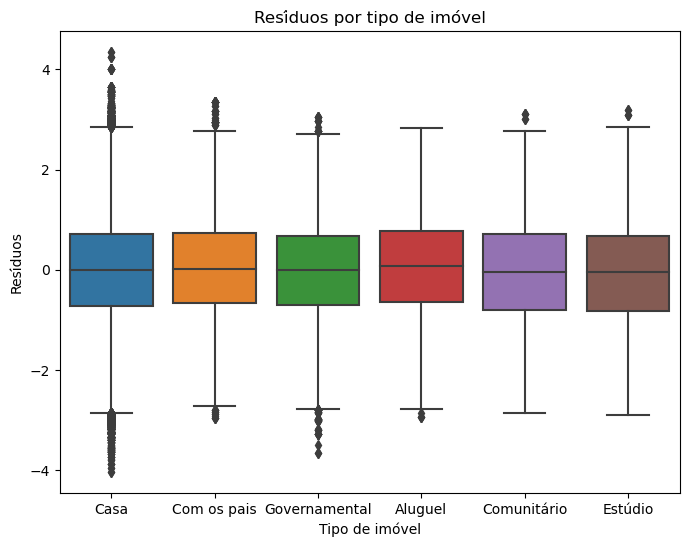

In [22]:
#Verificando padrão dos resíduos versus as variáveis explicativas
#Tipo de imovel

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=treino['tipo_residencia'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Tipo de imóvel')
plt.xticks(rotation=0)

ax.set_title('Resíduos por tipo de imóvel')

plt.show()

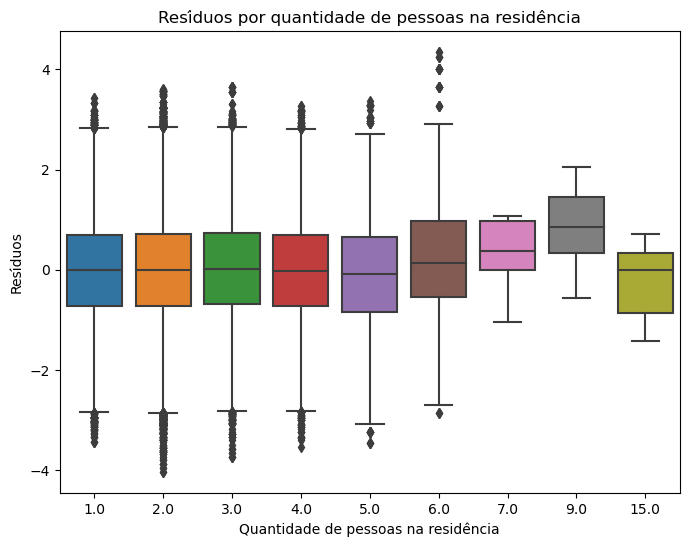

In [23]:
#Verificando padrão dos resíduos versus as variáveis explicativas
#Quantidade de pessoas na residência

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=treino['qt_pessoas_residencia'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Quantidade de pessoas na residência')

ax.set_title('Resíduos por quantidade de pessoas na residência')

plt.show()

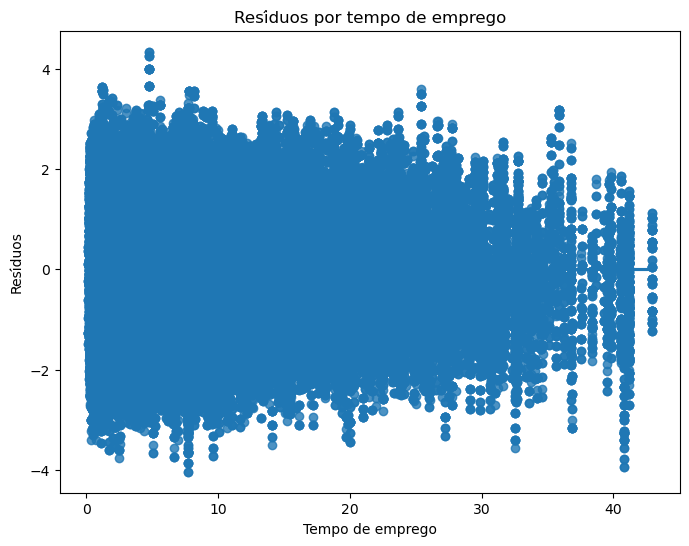

In [24]:
#Verificando padrão dos resíduos versus as variáveis explicativas
#Tempo de emprego

fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(x=treino['tempo_emprego'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Tempo de emprego')
plt.xticks(rotation=0)

ax.set_title('Resíduos por tempo de emprego')

plt.show()

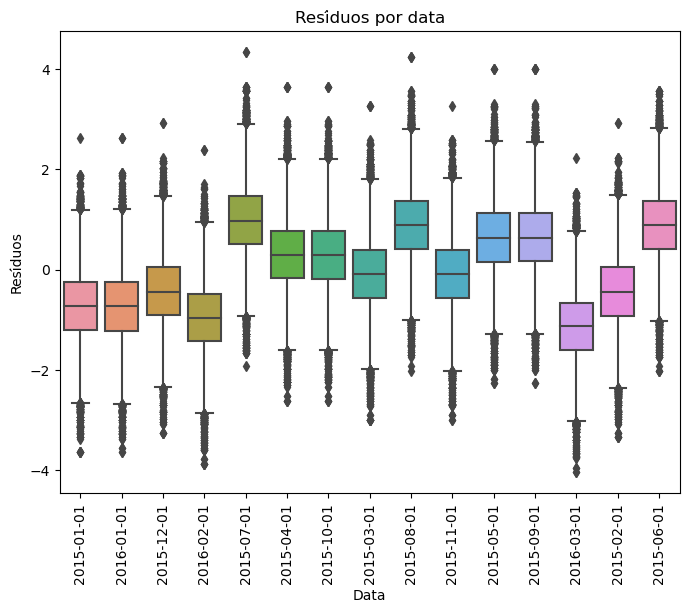

In [25]:
#Verificando padrão dos resíduos versus as variáveis explicativas
#Mes referência

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=treino['data_ref'], y=treino['residuos'])
ax.set_ylabel('Resíduos')
ax.set_xlabel('Data')
plt.xticks(rotation=90)
ax.set_title('Resíduos por data')

plt.show()

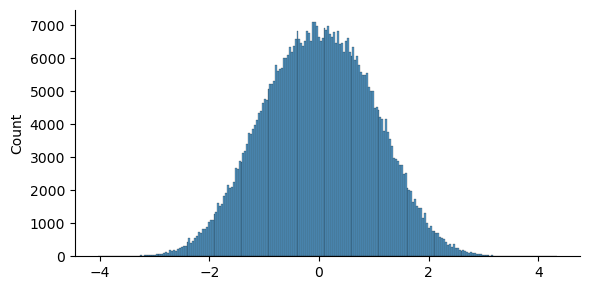

In [26]:
#Avalie se a variância da variável resposta parece ser conforme os valores previstos.

sns.displot(res.resid, height=3, aspect=2)

<Axes: >

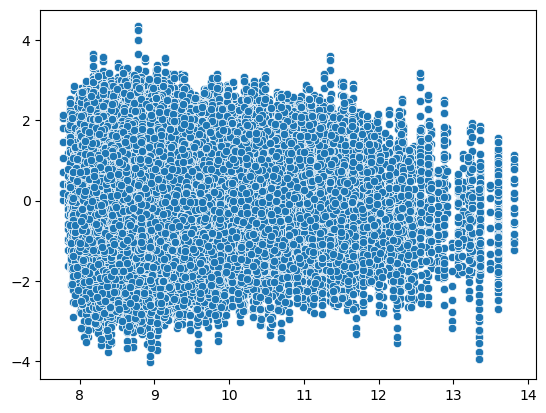

In [27]:
sns.scatterplot(x=res.predict(), y=res.resid)

# Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

Há um volume muito alto de outliers porém eles estão distribuidos uniformimente e parece não haver dependencia entre os dados. A escala da variabilidade pode ser resolvida num proximo modelo com a uniformização dos dados com base no StandardScaler().

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

<Axes: xlabel='media_tempo_emprego', ylabel='media_renda'>

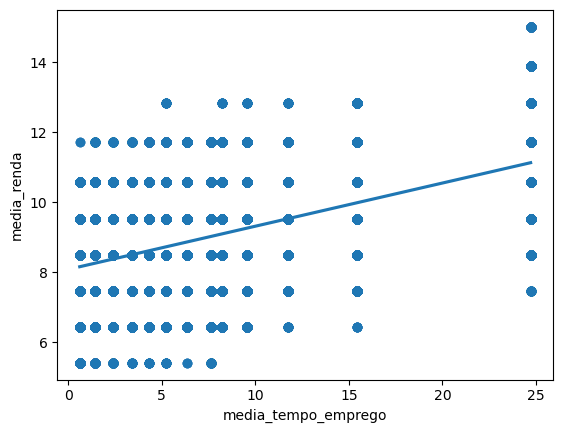

In [28]:
fig, ax = plt.subplots()

sns.regplot(x='media_tempo_emprego', y='media_renda', data=treino, ax=ax)

Text(0, 0.5, 'Resíduo')

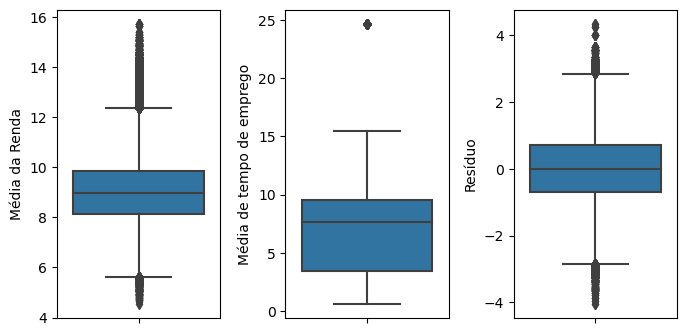

In [29]:
fix, ax = plt.subplots(1, 3, figsize=(8, 4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y='renda', data=treino, ax=ax[0])
sns.boxplot(y='media_tempo_emprego', data=treino, ax=ax[1])
sns.boxplot(y=res.resid, data=treino, ax=ax[2])

ax[0].set_ylabel('Média da Renda')
ax[1].set_ylabel('Média de tempo de emprego')
ax[2].set_ylabel('Resíduo')

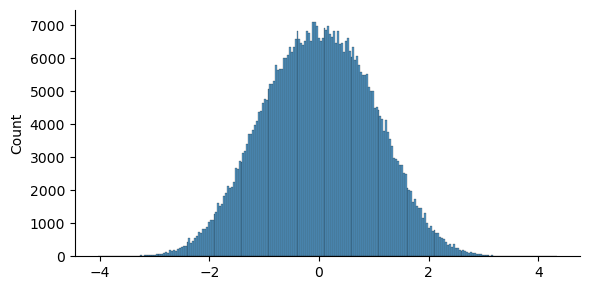

In [30]:
#Avaliando studentized residuals, verifique se há pontos que parecem ser discrepantes

st_res = res.get_influence().resid_studentized_internal

sns.displot(st_res, height=3, aspect=2)

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [31]:
#correlação de spearman
df.corr(method='spearman', numeric_only=True)

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,media_tempo_emprego,media_renda
qtd_filhos,1.000000,-0.415151,-0.089260,0.828600,-0.019957,-0.074798,-0.020033
idade,-0.415151,1.000000,0.300547,-0.350006,0.107999,0.275022,0.107196
tempo_emprego,-0.089260,0.300547,1.000000,-0.058139,0.501354,0.995632,0.489484
qt_pessoas_residencia,0.828600,-0.350006,-0.058139,1.000000,-0.008260,-0.044902,-0.008947
renda,-0.019957,0.107999,0.501354,-0.008260,1.000000,0.502920,0.964726
media_tempo_emprego,-0.074798,0.275022,0.995632,-0.044902,0.502920,1.000000,0.490856
media_renda,-0.020033,0.107196,0.489484,-0.008947,0.964726,0.490856,1.000000


In [32]:
#Avaliando o VIF

variaveis = [
    'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda',
    'idade', 'tempo_emprego', 'qt_pessoas_residencia'
]

df_dum = pd.get_dummies(df[variaveis], drop_first=True)
df_dum.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público
1970-01,0,47,16.717808,2.0,1,1,0,0,1,0,0
1970-01,0,30,9.600000,2.0,1,1,0,0,0,0,0
1970-01,0,28,8.208219,2.0,1,1,0,0,0,0,0
1970-01,2,44,1.301370,4.0,1,0,1,0,0,0,0
1970-01,2,33,1.254795,4.0,0,0,1,0,0,0,0


In [33]:
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(df_dum, i) for i in range(df_dum.shape[1])]
vars_vif["Feature"] = df_dum.columns

vars_vif.round(2)

,VIF Factor,Feature
0,5.79,qtd_filhos
1,16.62,idade
2,3.01,tempo_emprego
3,22.59,qt_pessoas_residencia
4,1.78,sexo_M
5,1.94,posse_de_veiculo_S
6,3.05,posse_de_imovel_S
7,1.00,tipo_renda_Bolsista
8,1.43,tipo_renda_Empresário
9,2.00,tipo_renda_Pensionista


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [34]:
#identificando os extremos de renda

df.sort_values(by='renda', ascending=False).head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,renda_cat,media_tempo_emprego,media_renda
1970-01,2015-07-01,F,N,N,0,Assalariado,Médio,Solteiro,Casa,56,35.89589,1.0,15.732766,"(18.337, 42.907]","(14.615, 15.733]",24.714134,15.020201
1970-01,2015-07-01,F,N,N,0,Assalariado,Médio,Solteiro,Casa,56,35.89589,1.0,15.732766,"(18.337, 42.907]","(14.615, 15.733]",24.714134,15.020201
1970-01,2015-07-01,F,N,N,0,Assalariado,Médio,Solteiro,Casa,56,35.89589,1.0,15.732766,"(18.337, 42.907]","(14.615, 15.733]",24.714134,15.020201
1970-01,2015-07-01,F,N,N,0,Assalariado,Médio,Solteiro,Casa,56,35.89589,1.0,15.732766,"(18.337, 42.907]","(14.615, 15.733]",24.714134,15.020201
1970-01,2015-07-01,F,N,N,0,Assalariado,Médio,Solteiro,Casa,56,35.89589,1.0,15.732766,"(18.337, 42.907]","(14.615, 15.733]",24.714134,15.020201


In [35]:
df.sort_values(by='renda', ascending=True).head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,renda_cat,media_tempo_emprego,media_renda
1970-01,2016-03-01,F,N,N,2,Assalariado,Médio,Casado,Casa,28,2.013699,4.0,4.55703,"(1.877, 2.912]","(4.546, 5.675]",2.381975,5.417881
1970-01,2016-03-01,F,N,N,2,Assalariado,Médio,Casado,Casa,28,2.013699,4.0,4.55703,"(1.877, 2.912]","(4.546, 5.675]",2.381975,5.417881
1970-01,2016-03-01,F,N,N,2,Assalariado,Médio,Casado,Casa,28,2.013699,4.0,4.55703,"(1.877, 2.912]","(4.546, 5.675]",2.381975,5.417881
1970-01,2016-03-01,F,N,N,2,Assalariado,Médio,Casado,Casa,28,2.013699,4.0,4.55703,"(1.877, 2.912]","(4.546, 5.675]",2.381975,5.417881
1970-01,2016-03-01,F,S,S,0,Assalariado,Médio,Casado,Casa,40,2.452055,2.0,4.60557,"(1.877, 2.912]","(4.546, 5.675]",2.381975,5.417881


In [36]:
df.sort_values(by='tempo_emprego', ascending=True).head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,renda_cat,media_tempo_emprego,media_renda
1970-01,2015-01-01,F,N,N,0,Assalariado,Fundamental,Casado,Aluguel,52,0.117808,2.0,6.649360,"(0.11699999999999999, 1.033]","(5.675, 6.792]",0.615629,6.450744
1970-01,2015-08-01,F,N,N,0,Assalariado,Fundamental,Casado,Aluguel,52,0.117808,2.0,8.276580,"(0.11699999999999999, 1.033]","(7.91, 9.027]",0.615629,8.495061
1970-01,2015-05-01,F,N,N,0,Assalariado,Fundamental,Casado,Aluguel,52,0.117808,2.0,8.026804,"(0.11699999999999999, 1.033]","(7.91, 9.027]",0.615629,8.495061
1970-01,2015-10-01,F,N,N,0,Assalariado,Fundamental,Casado,Aluguel,52,0.117808,2.0,7.677475,"(0.11699999999999999, 1.033]","(6.792, 7.91]",0.615629,7.468176
1970-01,2015-06-01,F,N,N,0,Assalariado,Fundamental,Casado,Aluguel,52,0.117808,2.0,8.276580,"(0.11699999999999999, 1.033]","(7.91, 9.027]",0.615629,8.495061


In [37]:
df.sort_values(by='tempo_emprego', ascending=False).head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,renda_cat,media_tempo_emprego,media_renda
1970-01,2016-02-01,F,N,S,0,Empresário,Superior completo,Casado,Casa,62,42.906849,2.0,12.987165,"(18.337, 42.907]","(12.38, 13.498]",24.714134,12.833354
1970-01,2016-02-01,F,N,S,0,Empresário,Superior completo,Casado,Casa,62,42.906849,2.0,12.987165,"(18.337, 42.907]","(12.38, 13.498]",24.714134,12.833354
1970-01,2015-12-01,F,N,S,0,Empresário,Médio,Casado,Casa,62,42.906849,2.0,13.510602,"(18.337, 42.907]","(13.498, 14.615]",24.714134,13.893276
1970-01,2016-03-01,F,N,S,0,Empresário,Médio,Casado,Casa,62,42.906849,2.0,12.821733,"(18.337, 42.907]","(12.38, 13.498]",24.714134,12.833354
1970-01,2015-06-01,F,N,S,0,Empresário,Médio,Casado,Casa,62,42.906849,2.0,14.597723,"(18.337, 42.907]","(13.498, 14.615]",24.714134,13.893276


In [38]:
df1 = df[(df['renda'] < 14.5) & (df['renda'] > 7) &
         (df['media_tempo_emprego'] < 30) &
         (df['media_tempo_emprego'] > 1)].dropna()

In [40]:
#Ajuste VIF

media_pessoa = df1['qt_pessoas_residencia'].groupby(df1.qtd_filhos).mean()
df1['media_pessoas'] = df1['qt_pessoas_residencia'] - df1['qtd_filhos'].map(
    media_pessoa)

media_idade = df1['idade'].groupby(df1.tempo_emprego).mean()
df1['media_idades'] = df1['idade'] - df1['tempo_emprego'].map(media_idade)

In [41]:
#Separando os dados entre treino e teste após ajuste

treino_1, teste_1 = train_test_split(df1, test_size=0.3, random_state=42)

In [42]:
variaveis = [
    'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda',
    'media_idades', 'tempo_emprego', 'media_pessoas'
]

df_dum = pd.get_dummies(treino_1[variaveis], drop_first=True)
df_dum.head()

vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(df_dum, i) for i in range(df_dum.shape[1])]
vars_vif["Feature"] = df_dum.columns

vars_vif.round(2)

,VIF Factor,Feature
0,1.38,qtd_filhos
1,1.03,media_idades
2,2.07,tempo_emprego
3,1.02,media_pessoas
4,1.68,sexo_M
5,1.86,posse_de_veiculo_S
6,2.37,posse_de_imovel_S
7,1.00,tipo_renda_Bolsista
8,1.31,tipo_renda_Empresário
9,1.31,tipo_renda_Pensionista


In [43]:
reg1 = smf.ols(
    'renda ~ sexo+posse_de_veiculo+posse_de_imovel+qtd_filhos+tipo_renda+media_idades+tempo_emprego+media_pessoas',
    data=treino_1).fit()
print(f'R-quadrado: {reg1.rsquared:.2%}')

reg1.summary()

R-quadrado: 38.74%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 2.713e+04
Date:                Fri, 12 May 2023   Prob (F-statistic):               0.00
Time:                        13:19:40   Log-Likelihood:            -6.3926e+05
No. Observations:              471978   AIC:                         1.279e+06
Df Residuals:                  471966   BIC:                         1.279e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          8.0501      0.004   2035.778      0.000       8.042       8.058
sexo[T.M]                          0.0628      0.003     19.486      0.000       0.056       0.069
posse_de_veiculo[T.S]              0.0116      0.003      3.797      0.000       0.006       0.018
posse_de_imovel[T.S]               0.1683      0.003     57.210      0.000       0.163       0.174
tipo_renda[T.Bolsista]            -0.1206      0.060     -2.016      0.044      -0.238      -0.003
tipo_renda[T.Empresário]           0.1346      0.003     38.730      0.000       0.128       0.141
tipo_renda[T.Pensionista]         -0.2569      0.004    -64.845      0.000      -0.265      -0.249
tipo_renda[T.Servidor público]     0.1250      0.005     24.969      0.000       0.115       0.135
qtd_filhos                        -0.0085      0.002     -4.363      0.000      -0.012      -0.005
media_idades                       0.0016      0.000      6.294      0.000       0.001       0.002
tempo_emprego                      0.1213      0.000    519.338      0.000       0.121       0.122
media_pessoas                     -0.0162      0.003     -4.817      0.000      -0.023      -0.010
==============================================================================
Omnibus:                     7112.163   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4973.669
Skew:                           0.141   Prob(JB):                         0.00
Kurtosis:                       2.583   Cond. No.                         455.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Resíduo')

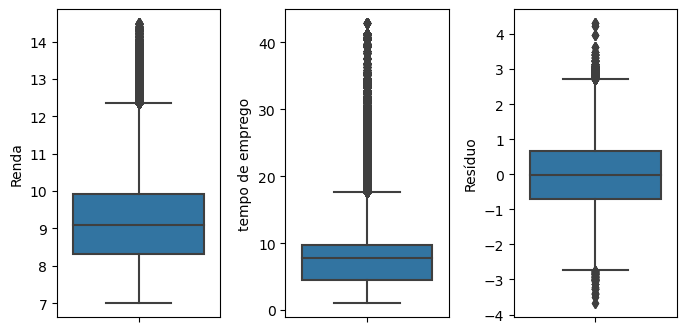

In [44]:
fix, ax = plt.subplots(1, 3, figsize=(8, 4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y='renda', data=treino_1, ax=ax[0])
sns.boxplot(y='tempo_emprego', data=treino_1, ax=ax[1])
sns.boxplot(y=reg1.resid, data=treino_1, ax=ax[2])

ax[0].set_ylabel('Renda')
ax[1].set_ylabel('tempo de emprego')
ax[2].set_ylabel('Resíduo')

In [48]:
resumo_1 = res.summary()
resumo_2 = reg1.summary()

print(
    f'Vamos observar a performance do modelo sem ajuste,R-quadrado: {res.rsquared:.2%}'
)
print(resumo_1)

print(
    '--------------------------------------------------------------------------------------------------------------'
)

print(
    f'Vamos observar a performance do modelo com ajuste, R-quadrado: {reg1.rsquared:.2%}'
)
print(resumo_2)

Vamos observar a performance do modelo sem ajuste,R-quadrado: 39.33%
                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 3.095e+04
Date:                Fri, 12 May 2023   Prob (F-statistic):               0.00
Time:                        13:20:59   Log-Likelihood:            -7.4527e+05
No. Observations:              525000   AIC:                         1.491e+06
Df Residuals:                  524988   BIC:                         1.491e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

In [55]:
#avaliando na base de teste sem ajuste.

y_pred = res.predict(teste[[
    'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda',
    'idade', 'tempo_emprego', 'qt_pessoas_residencia'
]])

r2_ajustado = r2_score(teste['renda'], y_pred)
print(f'R-quadrado ajustado: {r2_ajustado:.2%}')

R-quadrado ajustado: 39.27%


In [56]:
#avaliando na base de teste com ajuste.

y_pred = reg1.predict(teste_1[[
    'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda',
    'media_idades', 'tempo_emprego', 'media_pessoas'
]])

r2_ajustado = r2_score(teste_1['renda'], y_pred)
print(f'R-quadrado ajustado: {r2_ajustado:.2%}')

R-quadrado ajustado: 38.58%
